In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
from spynal.spikes import density
import sys

sys.path.append('../..')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

plt.style.use('../../sci_style.py')

# Load Data

In [3]:
# # session = 'Mary-Anesthesia-20160912-02'
# session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# # session = 'MrJones-Anesthesia-20160105-01'

# # session_list = ['Mary-Anesthesia-20160912-02',
# # 'MrJones-Anesthesia-20160109-01',
# # 'Mary-Anesthesia-20160826-02',
# # 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [4]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
section_times

{'wake': (0, 3548.040266666667),
 'induction': (3548.040266666667, 4441.511966666667),
 'anesthesia': (4441.511966666667, 7148.040266666667),
 'recovery': (7148.040266666667, 12191.767)}

In [9]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

# Sample Times

In [10]:
wake_bounds = section_times['wake']
anesthesia_bounds = (session_info['drugStart'][0] + 15*60, session_info['drugEnd'][1] - 15*60)

In [11]:
num_samples = 10

In [12]:
wake_times = np.sort(np.random.uniform(wake_bounds[0], wake_bounds[1], size=(num_samples,)))
anesthesia_times = np.sort(np.random.uniform(anesthesia_bounds[0], anesthesia_bounds[1], size=(num_samples,)))

In [13]:
np.array([float(f"{t:.3f}") for t in np.hstack([wake_times, anesthesia_times])])

array([6.087000e+00, 1.965710e+02, 6.197820e+02, 1.011209e+03,
       1.104607e+03, 1.625452e+03, 2.360015e+03, 2.763405e+03,
       2.909169e+03, 3.392827e+03, 4.627190e+03, 4.655418e+03,
       5.214456e+03, 5.399381e+03, 5.569436e+03, 5.660190e+03,
       5.864638e+03, 5.950157e+03, 6.061890e+03, 6.179057e+03])

# Collect Results

In [14]:
session_dir = f"/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/hyperparameter_testing/{session}"

In [15]:
def get_section(t, section_times):
    for section, bounds in section_times.items():
        if t >= bounds[0] and t < bounds[1]:
            return section

In [16]:
df_rows = []
param_folders = os.listdir(session_dir)
for param_folder in param_folders:
    param_dir = os.path.join(session_dir, param_folder)
    start_time_files = os.listdir(param_dir)
    for start_time_filename in start_time_files:
        start_time = float('.'.join(start_time_filename.split('.')[:2]))
        section = get_section(start_time, section_times)
        ret_file_path = os.path.join(param_dir, start_time_filename)
        ret = pd.read_pickle(ret_file_path)
        
        matrix_size = int(param_folder.split('=')[1].split('_')[0])
        rank = int(param_folder.split('=')[2].split('_')[0])
        
        num_to_show = np.min([int(0.1*len(ret['stability_params'])), rank])
        
        df_rows.append(dict(
            session=session,
            section=section,
            start_time=start_time,
            matrix_size=matrix_size,
            rank=rank,
            stability_params=np.array(ret['stability_params']),
            stability_freqs=np.array(ret['stability_freqs']),
            aic=ret['aic_val'],
            num_to_show=num_to_show
        ))

In [17]:
df = pd.DataFrame(df_rows)

In [18]:
np.unique(df.start_time, return_counts=True)

(array([ 113.906,  353.165,  867.291, 1111.808, 1593.264, 1869.73 ,
        3126.033, 3150.618, 3193.709, 3476.332, 4519.733, 4549.834,
        5036.493, 5072.027, 5085.11 , 5567.418, 5640.45 , 5830.915,
        6144.672]),
 array([187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
        187, 187, 187, 187, 187, 187]))

In [19]:
matrix_size_vals = np.sort(df.matrix_size.unique())
rank_vals = np.sort(df['rank'].unique())

aic_vals = np.zeros((len(matrix_size_vals), len(rank_vals)))

for i, matrix_size in enumerate(matrix_size_vals):
    for j, rank in enumerate(rank_vals):
        aic_vals[i, j] = df[(df.matrix_size == matrix_size) & (df['rank'] == rank)].aic.mean()

stability_curves = {}
aic_by_section = {}
for section in ['wake', 'anesthesia']:
    stability_curves[section] = {}
    aic_by_section[section] = np.zeros((len(matrix_size_vals), len(rank_vals)))
    section_df = df[(df.session == session) & (df.section == section)]
    
    for i, matrix_size in enumerate(matrix_size_vals):
        stability_curves[section][matrix_size] = {}
        for j, rank in enumerate(rank_vals):
            rel_rows = section_df[(section_df.matrix_size == matrix_size) & (section_df['rank'] == rank)]
            if len(rel_rows) > 0:
                stability_curves[section][matrix_size][rank] = np.vstack(rel_rows.stability_params)[:, :np.min(rel_rows.num_to_show)]     
            else:
                stability_curves[section][matrix_size][rank] = None
                
            aic_by_section[section][i, j] = section_df[(section_df.matrix_size == matrix_size) & (section_df['rank'] == rank)].aic.mean()

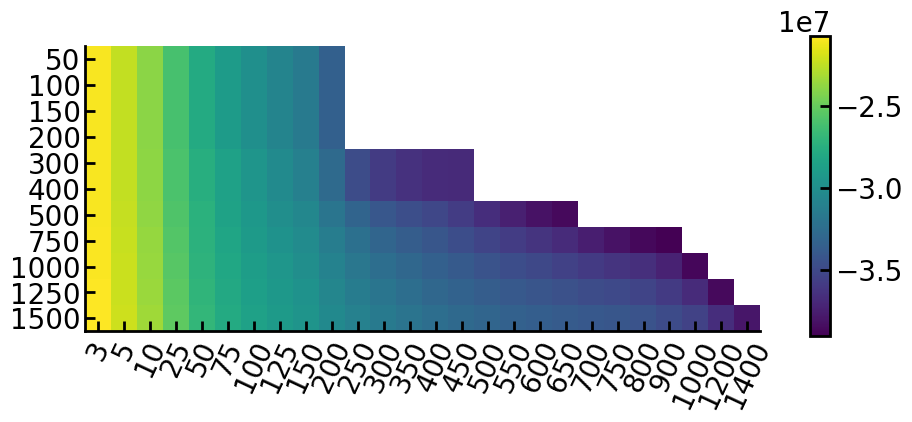

In [20]:
fig = plt.figure()
im = plt.imshow(aic_vals)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticks(np.arange(len(matrix_size_vals)))
ax.set_yticklabels(matrix_size_vals)
ax.set_xticks(np.arange(len(rank_vals)))
ax.set_xticklabels(rank_vals, rotation=65)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [21]:
# fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# ax = axs[0]
# im = ax.imshow(aic_by_section['wake'])
# ax.spines[['right', 'top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')
# plt.colorbar(im, ax=ax)

# ax = axs[1]
# im = ax.imshow(aic_by_section['anesthesia'])
# ax = plt.gca()
# ax.spines[['right', 'top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')
# plt.colorbar(im, ax=ax)

# plt.show()

In [22]:
section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange'
}

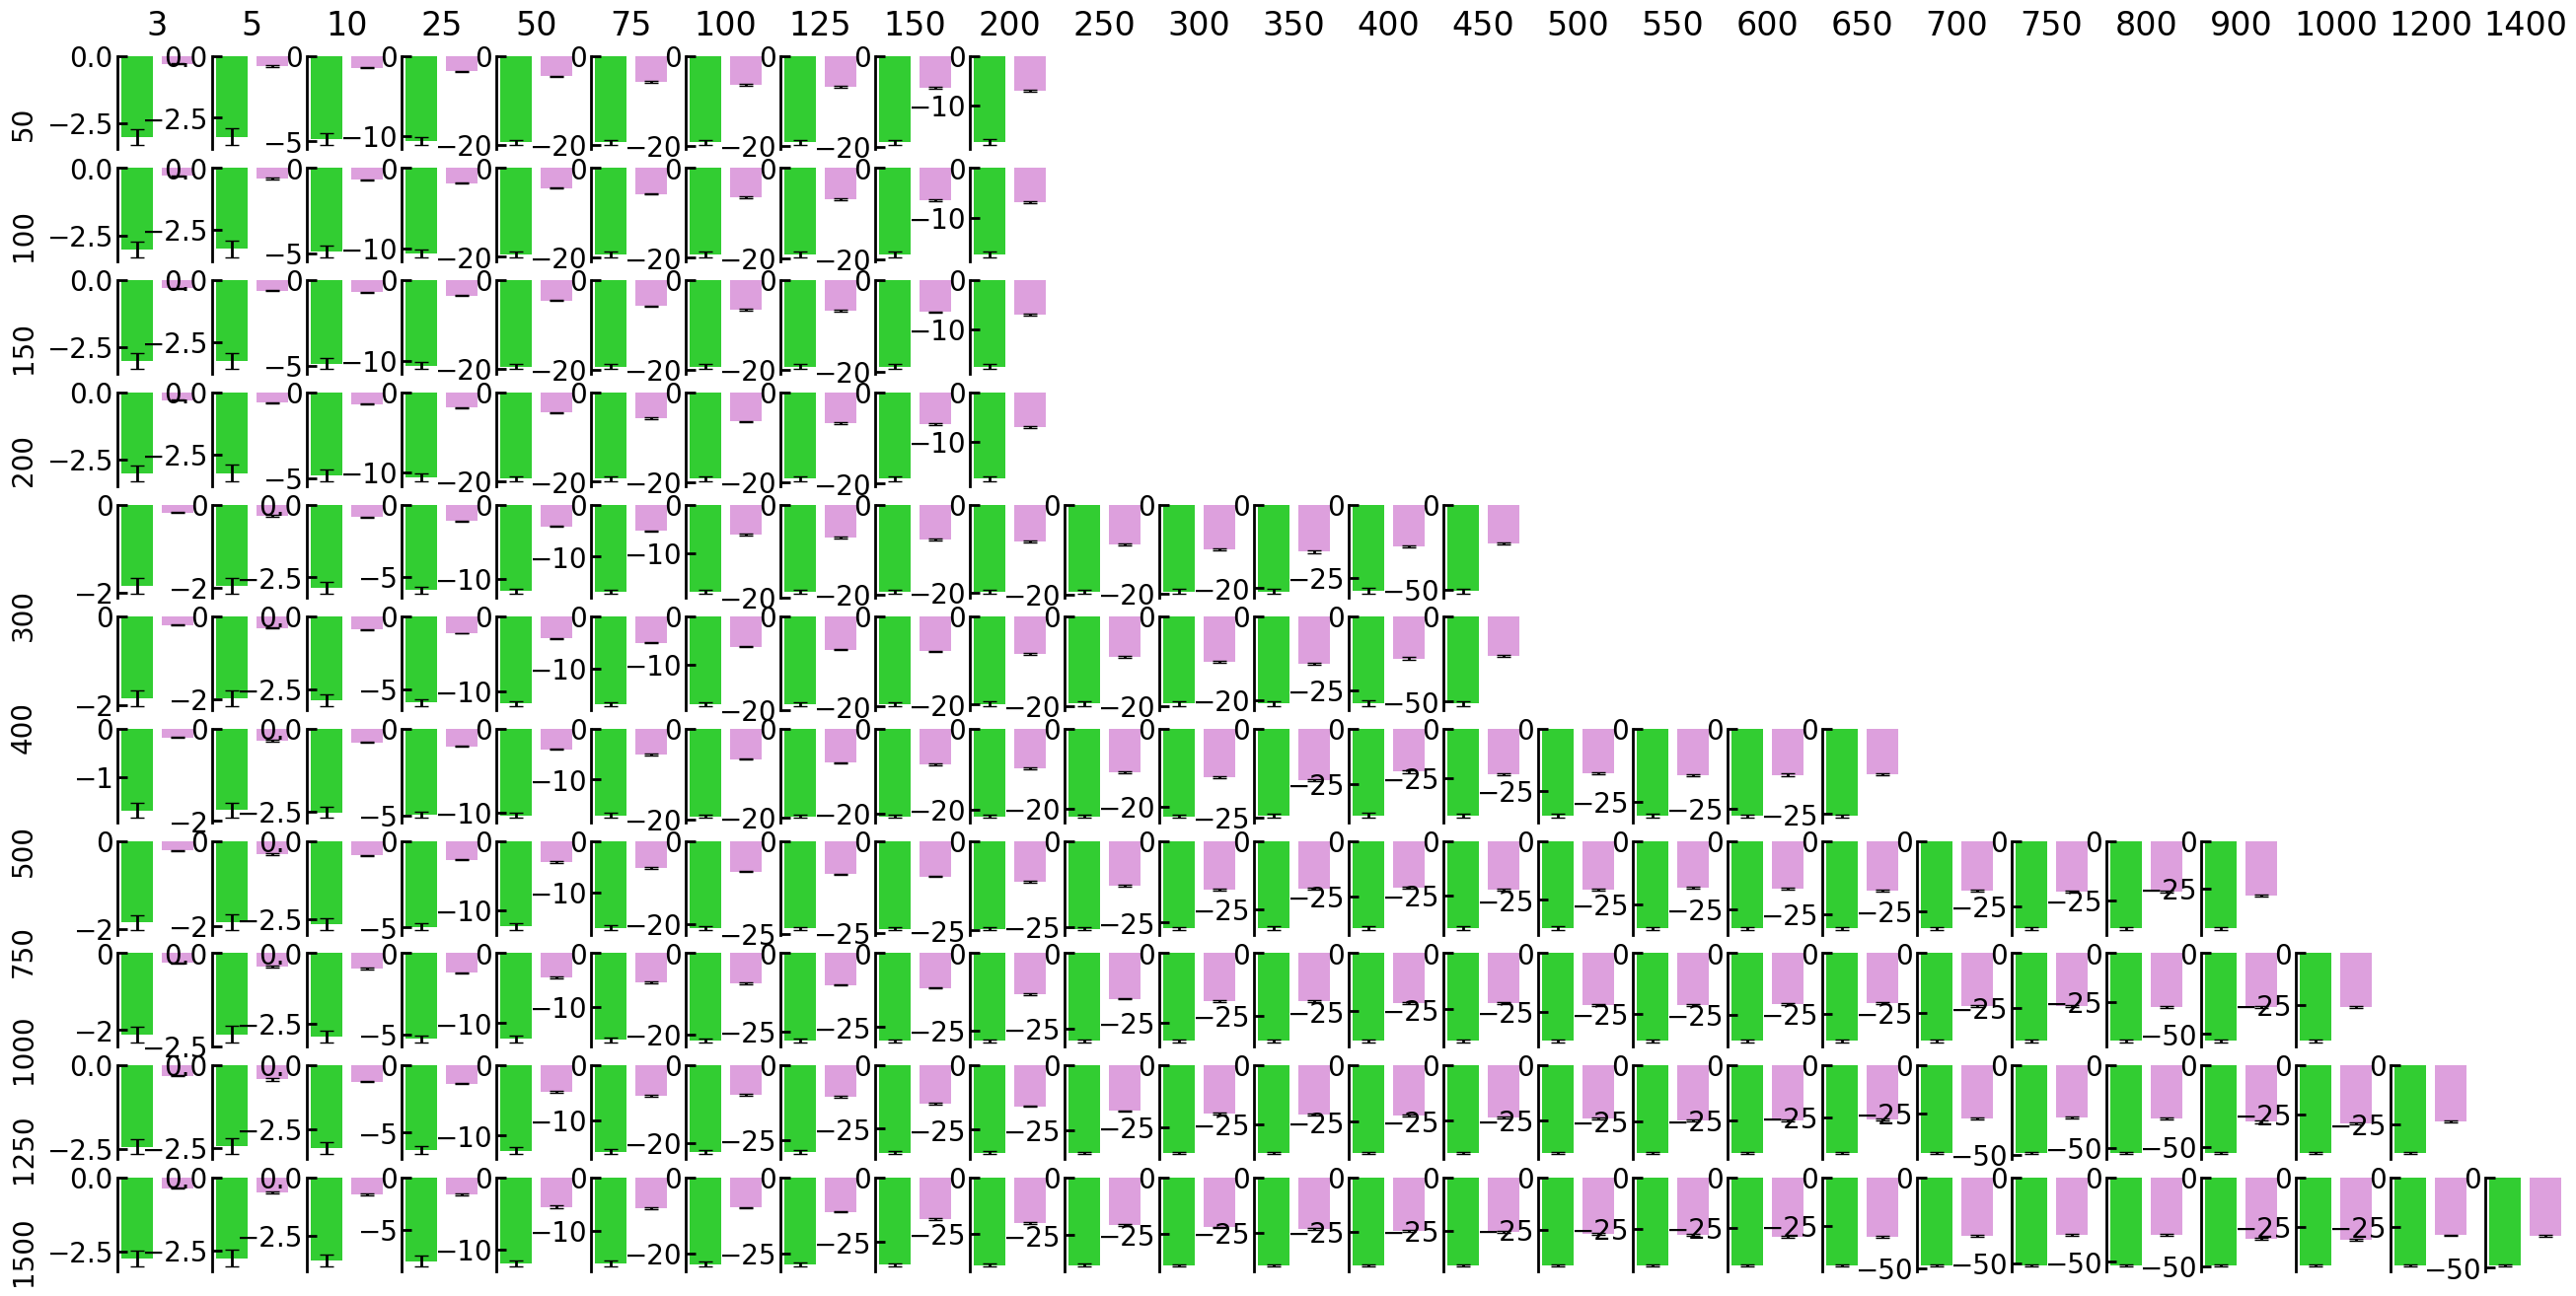

In [23]:
fig, axs = plt.subplots(len(matrix_size_vals), len(rank_vals), figsize=(32, 16))

labels = ['wake', 'anesthesia']
for i, matrix_size in enumerate(matrix_size_vals):
    for j, rank in enumerate(rank_vals):
        ax = axs[i, j]
        
        if np.sum([stability_curves[section][matrix_size][rank] is not None for section in labels]) == 2:
            bar_vals = [stability_curves[section][matrix_size][rank].mean() for section in labels]
            bar_errors = [stability_curves[section][matrix_size][rank].std()/np.sqrt(stability_curves[section][matrix_size][rank].size) for section in labels]
            ax.bar(labels, bar_vals, yerr=bar_errors, capsize=5, color=[section_colors['awake'], section_colors['unconscious']])
            ax.set_xticks([''])
            ax.spines[['right', 'top', 'bottom']].set_visible(False)
            # ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
        else:
            ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
        
        if i == 0:
            ax.set_title(f"{rank}")
        if j == 0:
            ax.text(-3.2, -2.5, f"{matrix_size}", rotation='vertical', verticalalignment='center')
        
# plt.tight_layout()
plt.show()